Demo of PMC working with different SNR ratios on two sine wave and noise

In [2]:
import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug', '/Applications/PyCharm.app/Contents/plugins/python/helpers/pydev', '/Users/david/Documents/mastersCode/ubm/classifiers/fhmm/development', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [3]:
from importlib import reload
import audio_datastore.audio_datastore as myads
reload(myads)
import numpy as np
import matplotlib.pyplot as plt
from spafe.features import mfcc
from importlib import reload
import hmmlearn.hmm as hmm
import utils
reload(utils)
from spafe.utils import vis
from matplotlib.pyplot import figure
figure(figsize=(4, 4), dpi=60)

<Figure size 240x240 with 0 Axes>

<Figure size 240x240 with 0 Axes>

In [4]:
import classifiers.fhmm.helper_functions as hf
reload(hf)

def adapt_speaker_model(hmm_a: hmm.GaussianHMM, hmm_b: hmm.GaussianHMM, snr):
    # 01 deconstruct hmm
    n_states = hmm_a.transmat_.shape[0]

    signal_cept = hf.StatParams(hmm_a.means_, hmm_a.covars_)
    noise_cept = hf.StatParams(hmm_b.means_, hmm_b.covars_)

    pm_signal = hf.ParamMapper(signal_cept.mu)
    pm_noisy = hf.ParamMapper(noise_cept.mu)

    signal_lin = pm_signal.map_cepstral_to_linear(signal_cept)
    noise_lin = pm_noisy.map_cepstral_to_linear(noise_cept)

    # 03 combine using snr
    combined_lin = hf.StatParams(
        signal_lin.mu + snr * noise_lin.mu,
        signal_lin.cov + ((np.square(snr)) * noise_lin.cov)
    )

    # 04 combined params in cept
    combined_cept = pm_signal.map_linear_to_cepstral(combined_lin)
    # combined_cept.mu[:, 0] = noise_cept.mu[:, 0]  # for some reason first gets confused
    # combined_cept['mu'][:, 1] = signal_cept['mu'][:, 1]

    # 05 combined hmm
    hmm_combined = hmm.GaussianHMM(n_states, covariance_type='diag')
    hmm_combined.n_features = hmm_a.covars_.shape[1]

    # hmm_combined.covars_ = np.array([np.diag(i) for i in combined_cept['cov']])
    hmm_combined.covars_ = np.array([np.diag(i) for i in combined_cept.cov])
    hmm_combined.means_ = combined_cept.mu
    hmm_combined.startprob_ = hmm_a.startprob_
    hmm_combined.transmat_ = hmm_a.transmat_

    return hmm_combined

# vis.show_features(cept_features, 'title', 'x', 'y')

def plot_params(params: hf.StatParams, gauss_hmm: hmm.GaussianHMM):
    x_axis = np.arange(len(params.mu.flatten()))
    params_var = np.diag(params.cov[0, :, :])
    hmm_var = np.diag(gauss_hmm.covars_[0, :, :])
    plt.stem(x_axis, params.mu.flatten() + params_var, linefmt='g')
    plt.stem(x_axis, params.mu.flatten() - params_var, linefmt='g')
    plt.stem(x_axis, params.mu.flatten(), linefmt='g')
    plt.stem(x_axis, gauss_hmm.means_.flatten() + hmm_var, linefmt='b', markerfmt ='*')
    plt.stem(x_axis, gauss_hmm.means_.flatten() - hmm_var, linefmt='b', markerfmt ='*')
    plt.stem(x_axis, gauss_hmm.means_.flatten(), linefmt='b', markerfmt ='*')

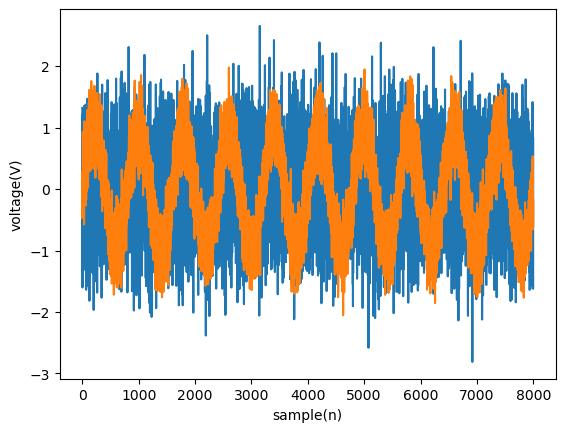

In [5]:
Fs = 8000
f1 = 20 # hz
f2 = 2000
sample = 8000
x = np.arange(sample)
n1 = np.random.normal(0, np.sqrt(0.1), sample)
n2 = np.random.normal(0, np.sqrt(0.5), sample)
n3 = np.random.normal(0, np.sqrt(0.58), sample)
s1 = np.sin(np.pi * f1 * x / Fs) + n1
s2 = n2
plt.plot(x, s2)
plt.plot(x, s1)
# plt.plot(x, noise)
plt.xlabel('sample(n)')
plt.ylabel('voltage(V)')
plt.show()

0.4936139496751153


0.4310344827586207

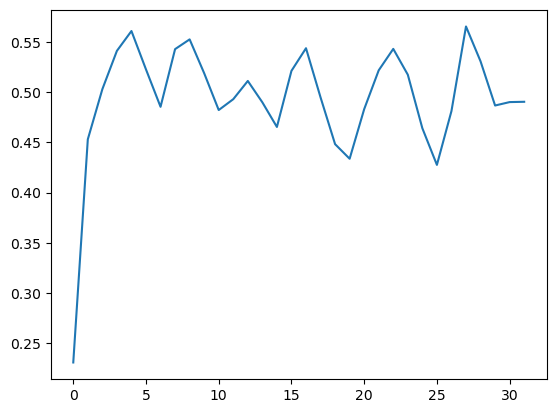

In [6]:
# snr before normalisation
ap = utils.periodic_power(s2, 500, 250)
plt.plot(ap)
print(np.mean(ap))
s1_ap = 0.58
s2_ap = 0.25
snr = 1 / (s1_ap / s2_ap)
snr

In [31]:
# import librosa
# s1_og = s1
# s2_og = s2
# s1 = librosa.util.normalize(s1)
# s2 = librosa.util.normalize(s2)

# plt.plot(x, s2)
# plt.plot(x, s1)
# # plt.plot(x, noise)
# plt.xlabel('sample(n)')
# plt.ylabel('voltage(V)')
# plt.show()

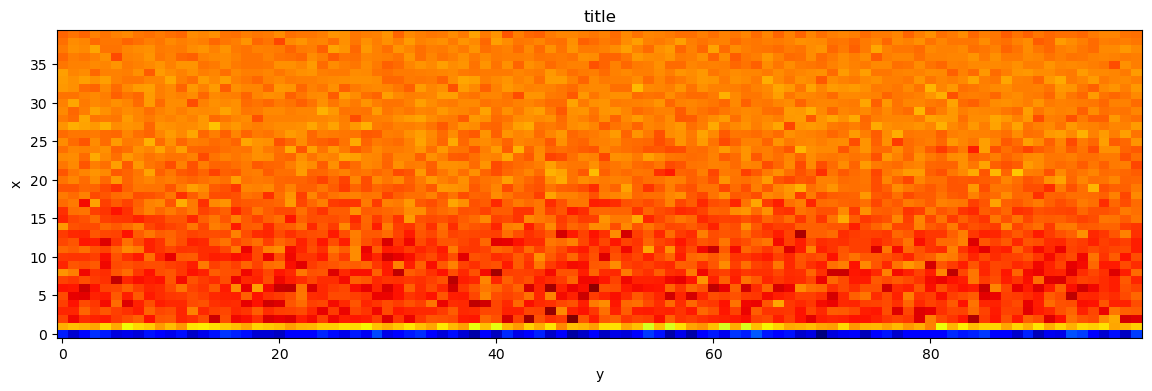

In [7]:
s1_feat = mfcc.mfcc(sig=s1, fs=8000, num_ceps=40, nfilts=40)
s1_hmm = hmm.GaussianHMM(1)
s1_hmm.fit(s1_feat)
s1_hmm_sampled, _ = s1_hmm.sample(100)
vis.show_features(s1_hmm_sampled, 'title', 'x', 'y')

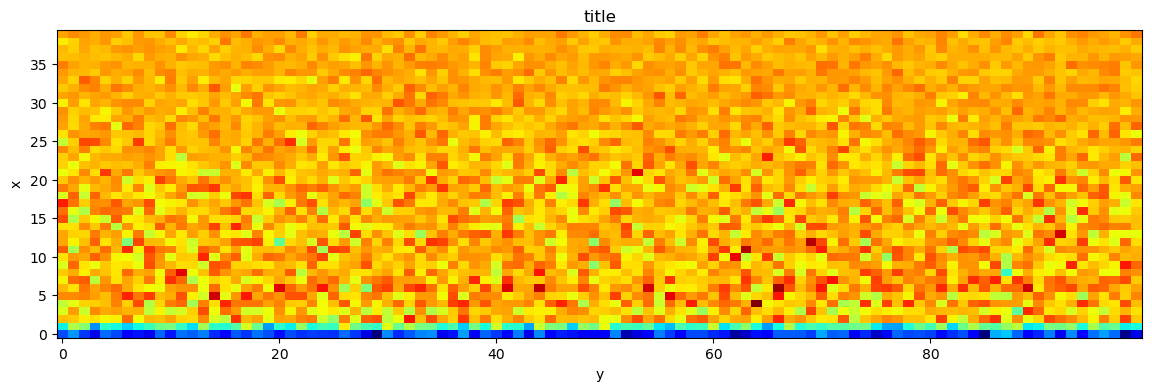

In [8]:
s2_feat = mfcc.mfcc(sig=s2, fs=8000, num_ceps=40, nfilts=40)
s2_hmm = hmm.GaussianHMM(1)
s2_hmm.fit(s2_feat)
s2_hmm_sampled, _ = s2_hmm.sample(100)
vis.show_features(s2_hmm_sampled, 'title', 'x', 'y')

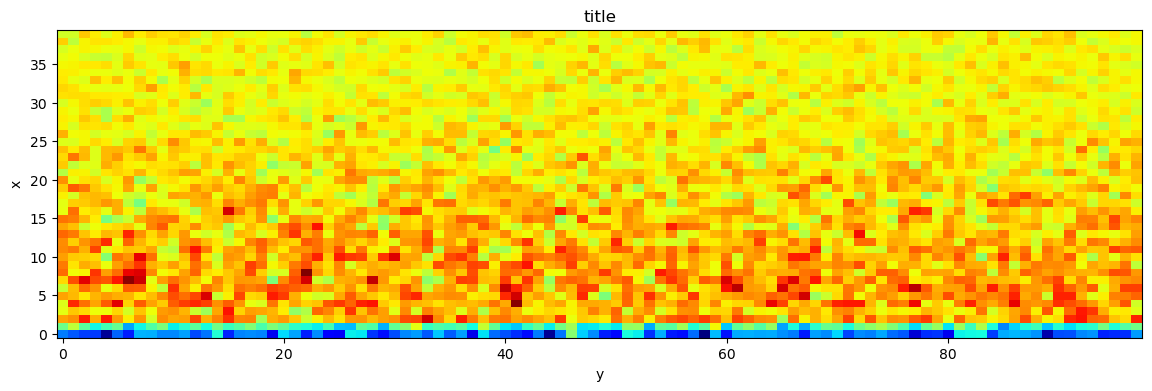

In [9]:
s3 = s1 + s2
s3_feat = mfcc.mfcc(sig=s3, fs=8000, num_ceps=40, nfilts=40)
vis.show_features(s3_feat[:100,:], 'title','x', 'y')

-3731.7588161648428 -3794.5037885200195 -10562.614326772507


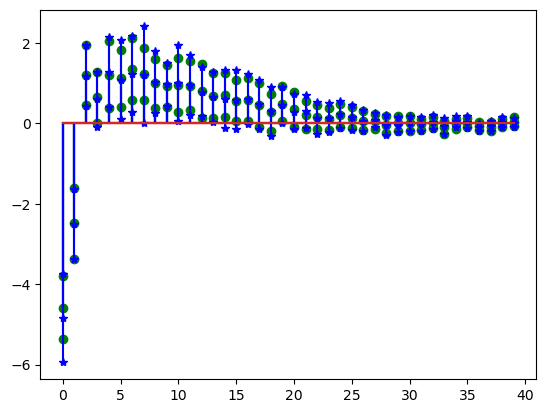

In [10]:
combined_hmm = adapt_speaker_model(s1_hmm, s2_hmm, 1)
s3_hmm = hmm.GaussianHMM(1)
s3_hmm.fit(s3_feat)

combined_params = hf.StatParams(combined_hmm.means_, combined_hmm.covars_)
plot_params(combined_params, s3_hmm)
print(s3_hmm.score(s3_feat), combined_hmm.score(s3_feat), s1_hmm.score(s3_feat))